# True val Calculations for Fig 8 (Chris)


## Panel A and C:
Normal was sampled from rnorm in R with mean=0 var=2
Cancer was sampled from rnorm in R with mean=0 var=1 

## Panel B and D
Normal was sampled from rnorm in R with mean=0 var=2
Cancer  90% sampled mean=0 var=1 and 10% sampled mean=5 var=1

(A) for each variable, compute the true/Bayes:
1. MI
2. correlation
3. AUC
4. pAUC
5. S@98
6. Accuracy
7. F1

(B) plot the true distributions, and sample, eg 512 samples (assuming normals are 50%) from them and overlay histograms

In [172]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd

sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

# helper function to truncate to 2 decimal places
def truncate(n, k=2):
    return int(n * 10**k) / 10**k

# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return '>'
    elif A < B:
        return '<'
    else:
        return '='

# helper function to plot the histgram and the pdf of a given data
# def plot_hist_pdf(x_1, x_2, pdf_class0, pdf_class1, title='Variable A'):
#     sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
#     PALETTE = sns.color_palette("Set1")
#     sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
#     # get the min and max of x_1 and x_2
#     xmin = min(x_1.min(), x_2.min())
#     xmax = max(x_1.max(), x_2.max())
#     x = np.linspace(xmin-1, xmax+1, 1000)
#     # create a df to plot the true pdfs using seaborn
#     df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0, 'pdf_class1': pdf_class1})
#     # plot the true pdfs
#     sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
#     sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
#     # sample from the true pdfs to plot the histograms
#     plt.hist(x_1, bins=100, density=True, alpha=0.5, color=PALETTE[1])
#     plt.hist(x_2, bins=100, density=True, alpha=0.5, color=PALETTE[0])
#     # set the labels and title
#     plt.xlabel('')
#     plt.ylabel('Density',size=1.0)
#     plt.xticks(size=15)
#     plt.yticks(size=15)
#     # set the legent size
#     sns.set_context("talk", font_scale=1.0)
#     plt.legend()
#     plt.title('title')
#     plt.show()

In [173]:


# Panel B & C Normal : N(0,2) vs Cancer  N(0,1)
# n = 25000
# n1_0 = int(n*0.9)
# n1_1 = int(n*0.1)
# p = 1
# mu_class0 = np.array([0]* p)
# mu_class1_0 = np.array([0]* p)
# mu_class1_1 = np.array([5]* p)
# sig_class0 = np.identity(p)*2
# sig_class1_0 = np.identity(p)*1
# sig_class1_1 = np.identity(p)*1
# p_class0, p_class1_0, p_class1_1 = 0.5, 0.5*0.9, 0.5*0.1

# # Create the probability density functions (PDFs) for the two Gaussian distributions
# pdf_class0 = multivariate_normal(mu_class0, sig_class0)
# pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
# pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
# pdf_class1 = np.zeros_like(pdf_class0)


# x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n)
# x_2_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
# x_2_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
# x_2 = np.vstack((x_2_0,x_2_1))

# x = np.vstack((x_1,x_2_0,x_2_1))
# y = np.array([0]*n+[1]*n).reshape(-1,1)

# p_x_given_class0 = pdf_class0.pdf(x)
# p_x_given_class1_0 = pdf_class1_0.pdf(x)
# p_x_given_class1_1 = pdf_class1_1.pdf(x)

# p_x_given_class1 = 0.9* p_x_given_class1_0 + 0.1* p_x_given_class1_1


# p_x = p_x_given_class0*p_class0 + p_x_given_class1_0*p_class1_0 + p_x_given_class1_1*p_class1_1
# pos_class0 = p_x_given_class0*p_class0/p_x
# # pos_class1_0 = p_x_given_class1_0*p_class1_0/p_x
# # pos_class1_1 = p_x_given_class1_1*p_class1_1/p_x
# pos_class1 = p_x_given_class1*0.5/p_x

# posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
# # print(posterior.shape)
# # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
# stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
# prior_y = np.array([p_class0,p_class1_0, p_class1_1])
# entropy_y = entropy(prior_y, base=np.exp(1))
# # print('entropy'+str(stats_conen))

# # # calculate correlation of two variables x_1 and x_2
# # correlation = np.corrcoef(x_1.T, x_2.T)
# # print('Correlation '+str(truncate(correlation[0,1], 4)))

# # # calculate MI
# # MI = entropy_y - stats_conen
# # print("MI "+str(truncate(MI)))

# # # calculate AUC
# # auc = roc_auc_score(y, posterior[:,1])
# # print('AUC '+ str(truncate(auc)))
# # # calculate 
# # pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
# # print('pAUC '+ str(truncate(pauc)))

# # fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
# # # plt.plot(fpr,tpr)
# # tpr_s = np.max(tpr[fpr <= 0.02])
# # print('S@98 '+ str(truncate(tpr_s)))
# # # calculate accuracy

# # y_pred = np.argmax(posterior, axis=1)
# # accuracy = metrics.accuracy_score(y, y_pred)
# # print('Accuracy '+ str(truncate(accuracy)))

# # # calculate F1
# # y_pred = np.argmax(posterior, axis=1)
# # f1 = metrics.f1_score(y, y_pred)
# # print('F1 '+ str(truncate(f1)))

# correlation = np.corrcoef(x_1.T, x_2.T)
# MI = entropy_y - stats_conen
# auc = roc_auc_score(y, posterior[:,1])
# pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
# fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
# tpr_s = np.max(tpr[fpr <= 0.02])
# y_pred = np.argmax(posterior, axis=1)   
# accuracy = metrics.accuracy_score(y, y_pred)
# tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
# sensitivity = tp/(tp+fn)
# specificity = tn/(tn+fp)
# f1 = metrics.f1_score(y, y_pred)
# report = metrics.classification_report(y, y_pred)

# statistics_B = {'Correlation': truncate(correlation[0,1], 4), 
#                 'MI': truncate(MI), 
#                 'AUC': truncate(auc), 
#                 'pAUC': truncate(pauc), 
#                 'S@98': truncate(tpr_s), 
#                 'Sensitivity': truncate(sensitivity), 
#                 'Specificity': truncate(specificity), 
#                 'Accuracy': truncate(accuracy), 
#                 'F1': truncate(f1), 
#                 'TN': tn, 
#                 'FP': fp, 
#                 'FN': fn, 
#                 'TP': tp}
# statistics_B_list = list(statistics_B.values())
# # print the statistics as a dataframe
# print(pd.DataFrame(statistics_B_list, index=statistics_B.keys(), columns=['Variable B']))

# # # plot the true pdfs
# # x = np.linspace(-5, 10, 1000)
# # plt.plot(x, pdf_class0.pdf(x), label='Control', color='b')
# # plt.plot(x, 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x), label='Cancer', color='r')
# # # plt.plot(x, pdf_class1_1.pdf(x), label='N(5,1)', color='b')
# # # sample from the true pdfs to plot the histograms
# # plt.hist(x_1, bins=100, density=True, alpha=0.5, color='b')
# # # combine the two cancer classes
# # x_2 = np.vstack((x_2_0,x_2_1))
# # plt.hist(x_2, bins=100, density=True, alpha=0.5, color='r')

# # plt.legend()
# # plt.title('Variable B')

# # plot the true pdfs using seaborn
# x = np.linspace(-5, 10, 1000)
# # create a df to plot the true pdfs using seaborn
# df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x)})
# # plot the true pdfs
# sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
# sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
# # sample from the true pdfs to plot the histograms
# plt.hist(x_1, bins=100, density=True, alpha=0.5, color=PALETTE[1])
# plt.hist(x_2, bins=100, density=True, alpha=0.5, color=PALETTE[0])

# # set the labels and title
# plt.xlabel('')
# plt.ylabel('Density',size=.5)
# # set the ticks size
# plt.xticks(size=15)
# plt.yticks(size=15)
# # set the legent size
# sns.set_context("talk", font_scale=1.0)
# plt.legend()
# plt.title('Variable B')


In [174]:
# Define a function to calculate the statistics for Variable B
def calculate_statistics_B(n, n1_0, n1_1, p, mu_class0, mu_class1_0, mu_class1_1, sig_class0, sig_class1_0, sig_class1_1, p_class0, p_class1_0, p_class1_1, plot=False):
    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
    pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
    pdf_class1 = np.zeros_like(pdf_class0)

    x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n)
    x_2_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
    x_2_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
    x_2 = np.vstack((x_2_0,x_2_1))

    x = np.vstack((x_1,x_2_0,x_2_1))
    y = np.array([0]*n+[1]*n).reshape(-1,1)

    p_x_given_class0 = pdf_class0.pdf(x)
    p_x_given_class1_0 = pdf_class1_0.pdf(x)
    p_x_given_class1_1 = pdf_class1_1.pdf(x)

    p_x_given_class1 = 0.9* p_x_given_class1_0 + 0.1* p_x_given_class1_1

    p_x = p_x_given_class0*p_class0 + p_x_given_class1_0*p_class1_0 + p_x_given_class1_1*p_class1_1
    pos_class0 = p_x_given_class0*p_class0/p_x
    pos_class1 = p_x_given_class1*0.5/p_x

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1_0, p_class1_1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    correlation = np.corrcoef(x_1.T, x_2.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:,1])
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)   
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = metrics.f1_score(y, y_pred)
    report = metrics.classification_report(y, y_pred)

    statistics_B = {'Correlation': truncate(correlation[0,1], 4), 
                    'Accuracy': truncate(accuracy), 
                    'AUC': truncate(auc), 
                    'pAUC': truncate(pauc), 
                    'S@98': truncate(tpr_s), 
                    'Sensitivity': truncate(sensitivity), 
                    'Specificity': truncate(specificity), 
                    'F1': truncate(f1), 
                    'MI': truncate(MI), 
                    'TN': tn, 
                    'FP': fp, 
                    'FN': fn, 
                    'TP': tp}
    if plot:
        # plot the true pdfs using seaborn
        x = np.linspace(-5, 10, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x)})
        # plot the true pdfs
        sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
        sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=True, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=True, alpha=0.5, color=PALETTE[0])

        # set the labels and title
        plt.xlabel('')
        plt.ylabel('Density',size=.5)
        # set the ticks size
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.legend()
        plt.title('Variable B')
    return statistics_B, report

/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

,Variable B
Correlation,0.0031
Accuracy,0.5900
AUC,0.6300
pAUC,0.5500
S@98,0.1100
Sensitivity,0.7000
Specificity,0.4700
F1,0.6300
MI,0.2100
TN,11970.0000


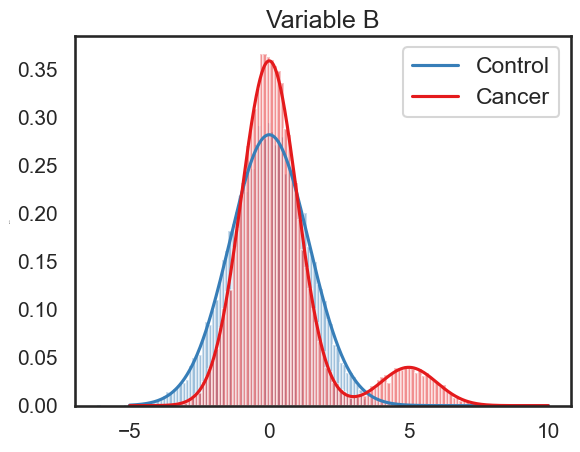

In [182]:
n = 25000
n1_0 = int(n*0.9)
n1_1 = int(n*0.1)
p = 1
mu_class0 = np.array([0]* p)
mu_class1_0 = np.array([0]* p)
mu_class1_1 = np.array([5]* p)
sig_class0 = np.identity(p)*2
sig_class1_0 = np.identity(p)*1
sig_class1_1 = np.identity(p)*1
p_class0, p_class1_0, p_class1_1 = 0.5, 0.5*0.9, 0.5*0.1

statistics_B, report = calculate_statistics_B(n, n1_0, n1_1, p, mu_class0, mu_class1_0, mu_class1_1, sig_class0, sig_class1_0, sig_class1_1, p_class0, p_class1_0, p_class1_1, plot=True)
statistics_B_list = np.array(list(statistics_B.values()))
# print the statistics as a dataframe
pd.DataFrame(statistics_B_list, index=statistics_B.keys(), columns=['Variable B'])

In [176]:
# # Panel B & D Normal : N(0,2) vs Cancer  N(0,1)
# n = 25000
# p = 1
# mu_class0 = np.array([0]* p)
# mu_class1 = np.array([0]* p)
# sig_class0 = np.identity(p)*4
# sig_class1 = np.identity(p)*1
# p_class0, p_class1 = 0.5, 0.5

# # Create the probability density functions (PDFs) for the two Gaussian distributions
# pdf_class0 = multivariate_normal(mu_class0, sig_class0)
# pdf_class1 = multivariate_normal(mu_class1, sig_class1)


# x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n)
# x_2 = np.random.multivariate_normal(mu_class1, sig_class1, size=n)

# x = np.vstack((x_1,x_2))
# y = np.array([0]*n+[1]*n).reshape(-1,1)

# p_x_given_class0 = pdf_class0.pdf(x)
# p_x_given_class1 = pdf_class1.pdf(x)


# p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
# pos_class0 = p_x_given_class0*p_class0/p_x
# pos_class1 = p_x_given_class1*p_class1/p_x


# posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
# # print(posterior.shape)
# # display(posterior[:5])
# # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
# stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
# prior_y = np.array([p_class0,p_class1])
# entropy_y = entropy(prior_y, base=np.exp(1))

# # # calculate correlation of two variables x_1 and x_2
# # correlation = np.corrcoef(x_1.T, x_2.T)
# # print('Correlation '+str(truncate(correlation[0,1], 4)))

# # # print('entropy'+str(stats_conen))
# # MI = entropy_y - stats_conen
# # print("MI "+str(truncate(MI)))

# # # calculate AUC
# # auc = roc_auc_score(y, posterior[:,1])
# # print('AUC '+ str(truncate(auc)))
# # # calculate 
# # pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
# # print('pAUC '+ str(truncate(pauc)))

# # fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
# # # plt.plot(fpr,tpr)
# # tpr_s = np.max(tpr[fpr <= 0.02])
# # print('S@98 '+ str(truncate(tpr_s)))

# # # calculate accuracy
# # y_pred = np.argmax(posterior, axis=1)
# # accuracy = metrics.accuracy_score(y, y_pred)
# # print('Accuracy '+ str(truncate(accuracy)))

# # # calculate F1
# # y_pred = np.argmax(posterior, axis=1)
# # f1 = metrics.f1_score(y, y_pred)
# # print('F1 '+ str(truncate(f1)))

# correlation = np.corrcoef(x_1.T, x_2.T)
# MI = entropy_y - stats_conen
# auc = roc_auc_score(y, posterior[:,1])
# pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
# fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
# tpr_s = np.max(tpr[fpr <= 0.02])
# y_pred = np.argmax(posterior, axis=1)   
# accuracy = metrics.accuracy_score(y, y_pred)
# tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
# sensitivity = tp/(tp+fn)
# specificity = tn/(tn+fp)
# f1 = metrics.f1_score(y, y_pred)
# report = metrics.classification_report(y, y_pred)

# statistics_A = {'Correlation': truncate(correlation[0,1], 4), 
#                 'MI': truncate(MI, 2), 
#                 'AUC': truncate(auc, 2), 
#                 'pAUC': truncate(pauc), 
#                 'S@98': truncate(tpr_s), 
#                 'Sensitivity': truncate(sensitivity), 
#                 'Specificity': truncate(specificity), 
#                 'Accuracy': truncate(accuracy), 
#                 'F1': truncate(f1), 
#                 'TN': tn, 
#                 'FP': fp, 
#                 'FN': fn, 
#                 'TP': tp}

# statistics_A_list = list(statistics_A.values())
# # print the statistics as a dataframe
# print(pd.DataFrame(statistics_A_list, index=statistics_A.keys(), columns=['Variable A']))
# # plot the true pdfs using seaborn
# x = np.linspace(-5, 5, 1000)
# # create a df to plot the true pdfs using seaborn
# df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': pdf_class1.pdf(x)})
# # plot the true pdfs
# sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
# sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
# # sample from the true pdfs to plot the histograms
# plt.hist(x_1, bins=100, density=True, alpha=0.5, color=PALETTE[1])
# plt.hist(x_2, bins=100, density=True, alpha=0.5, color=PALETTE[0])

# # set the labels and title
# plt.xlabel('')
# plt.ylabel('Density',size=1.0)
# plt.xticks(size=15)
# plt.yticks(size=15)
# # set the legent size
# sns.set_context("talk", font_scale=1.0)
# plt.legend()
# plt.title('Variable A')

In [170]:
# define a function to generate the statistics
def generate_statistics_A(n, p, mu_class0, mu_class1, sig_class0, sig_class1, p_class0, p_class1, plot=False):
    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    pdf_class1 = multivariate_normal(mu_class1, sig_class1)

    x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n)
    x_2 = np.random.multivariate_normal(mu_class1, sig_class1, size=n)

    x = np.vstack((x_1,x_2))
    y = np.array([0]*n+[1]*n).reshape(-1,1)

    p_x_given_class0 = pdf_class0.pdf(x)
    p_x_given_class1 = pdf_class1.pdf(x)

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
    pos_class0 = p_x_given_class0*p_class0/p_x
    pos_class1 = p_x_given_class1*p_class1/p_x

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    correlation = np.corrcoef(x_1.T, x_2.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:,1])
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)   
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = metrics.f1_score(y, y_pred)
    report = metrics.classification_report(y, y_pred)
    # return MI, auc, pauc, tpr_s, sensitivity, specificity, accuracy, f1, report,  tn, fp, fn, tp
    # create a dictionary to store the statistics in order of correlation, accuracy, AUC, pAUC, F1,  MI, S@98, Sensitivity, Specificity, F1, TN, FP, FN, TP, report
    statistics_A = {'Correlation': truncate(correlation[0,1], 4), 
                    'Accuracy': truncate(accuracy), 
                    'AUC': truncate(auc), 
                    'pAUC': truncate(pauc), 
                    'S@98': truncate(tpr_s), 
                    'Sensitivity': truncate(sensitivity), 
                    'Specificity': truncate(specificity), 
                    'F1': truncate(f1), 
                    'MI': truncate(MI), 
                    'TN': tn, 
                    'FP': fp, 
                    'FN': fn, 
                    'TP': tp}
    # if plot is True, plot the true pdfs using seaborn
    if plot:
        sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
        PALETTE = sns.color_palette("Set1")
        sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
        x = np.linspace(-5, 5, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': pdf_class1.pdf(x)})
        # plot the true pdfs
        sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
        sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=True, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=True, alpha=0.5, color=PALETTE[0])
        # set the labels and title
        plt.xlabel('')
        plt.ylabel('Density',size=1.0)
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.legend()
        plt.title('Variable A')
    return statistics_A, report

/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

,Variable A,Relations,Variable B
Correlation,0.0066,>,-0.0032
Accuracy,0.65,>,0.59
AUC,0.7,>,0.63
pAUC,0.52,<,0.55
S@98,0.04,<,0.1
Sensitivity,0.82,>,0.7
Specificity,0.49,>,0.48
F1,0.7,>,0.63
MI,0.09,<,0.21
TN,12312.0,>,12068.0


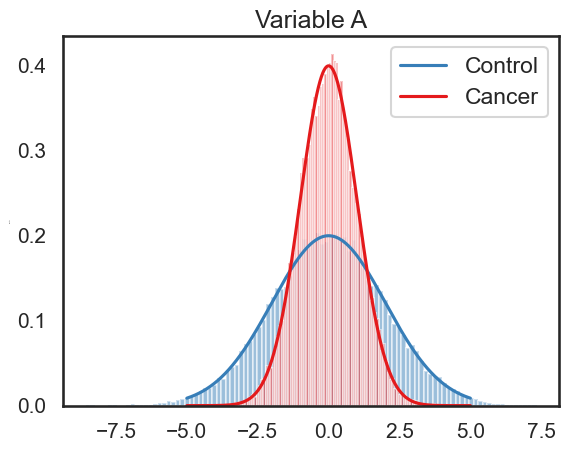

In [171]:
n = 25000
p = 1
mu_class0 = np.array([0]* p)
mu_class1 = np.array([0]* p)
sig_class0 = np.identity(p)*4
sig_class1 = np.identity(p)*1
p_class0, p_class1 = 0.5, 0.5
statistics_A, report = generate_statistics_A(n, p, mu_class0, mu_class1, sig_class0, sig_class1, p_class0, p_class1, plot=True)
statistics_A_list = np.array(list(statistics_A.values()))
# generate function to return '>' if the value A is greater than B, '<' if the value A is less than B, and '=' if the values are equal
relations = np.array([compare(statistics_A_list[i], statistics_B_list[i]) for i in range(len(statistics_A_list))])
# print the statistics as a dataframe
pd.DataFrame(np.vstack((statistics_A_list, relations, statistics_B_list)).T, index=statistics_A.keys(), columns=['Variable A', 'Relations', 'Variable B'])
# print('Accuracy '+str(truncate(accuracy)))
# print('AUC '+str(truncate(auc)))
# print('F1 '+str(truncate(f1)))
# print('MI '+str(truncate(MI)))
# print('pAUC '+str(truncate(pauc)))
# print('S@98 '+str(truncate(tpr_s)))
# print('Sensitivity '+str(truncate(sensitivity)))
# print('Specificity '+str(truncate(specificity)))
# print('recall '+str(truncate(tp/(tp+fn))))
# print('precision '+str(truncate(tp/(tp+fp))))
# print('report '+str(report))


/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

,Variable A,Relations,Variable B
Correlation,0.0015,<,0.0031
Accuracy,0.83,>,0.59
AUC,0.91,>,0.63
pAUC,0.78,>,0.55
S@98,0.46,>,0.11
Sensitivity,0.83,>,0.7
Specificity,0.83,>,0.47
F1,0.83,>,0.63
MI,0.33,>,0.21
TN,20941.0,>,11970.0


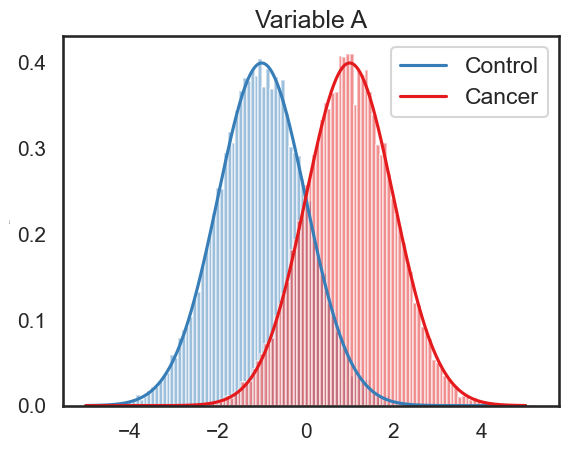

In [188]:
n = 25000
p = 1
mu_class0 = np.array([-1]* p)
mu_class1 = np.array([1]* p)
sig_class0 = np.identity(p)*1
sig_class1 = np.identity(p)*1
p_class0, p_class1 = 0.5, 0.5
statistics_A, report = generate_statistics_A(n, p, mu_class0, mu_class1, sig_class0, sig_class1, p_class0, p_class1, plot=True)
statistics_A_list = np.array(list(statistics_A.values()))
# generate function to return '>' if the value A is greater than B, '<' if the value A is less than B, and '=' if the values are equal
relations = np.array([compare(statistics_A_list[i], statistics_B_list[i]) for i in range(len(statistics_A_list))])
# print the statistics as a dataframe
df = pd.DataFrame(np.vstack((statistics_A_list, relations, statistics_B_list)).T, index=statistics_A.keys(), columns=['Variable A', 'Relations', 'Variable B'])
df

In [189]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
 & Variable A & Relations & Variable B \\
\midrule
Correlation & 0.0015 & < & 0.0031 \\
Accuracy & 0.83 & > & 0.59 \\
AUC & 0.91 & > & 0.63 \\
pAUC & 0.78 & > & 0.55 \\
S@98 & 0.46 & > & 0.11 \\
Sensitivity & 0.83 & > & 0.7 \\
Specificity & 0.83 & > & 0.47 \\
F1 & 0.83 & > & 0.63 \\
MI & 0.33 & > & 0.21 \\
TN & 20941.0 & > & 11970.0 \\
FP & 4059.0 & < & 13030.0 \\
FN & 4069.0 & < & 7372.0 \\
TP & 20931.0 & > & 17628.0 \\
\bottomrule
\end{tabular}

